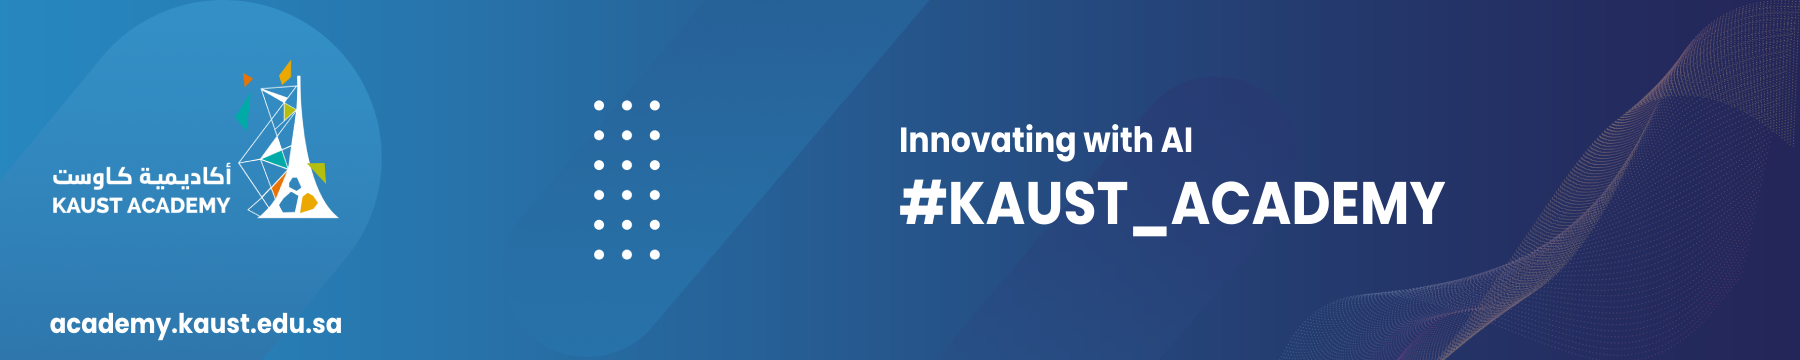

This notebook has been inspired by [Q* Learning with FrozenLakev2.ipynb](https://colab.research.google.com/github/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Q_Learning_with_FrozenLakev2.ipynb#scrollTo=Xr9nI6dcQM8I) and [Deep Reinforcement Learning Course](https://huggingface.co/learn/deep-rl-course/unit0/introduction?fw=pt) by Thomas Simonini

# Q-Learning

In this notebook, we will implement Q-Learning Reinforcement learning algorithm for Frozen Lake Environment.

## Frozen Lake

Frozen lake is a toy text environment involves crossing a frozen lake from start to goal without falling into any holes by walking over the frozen lake. <br>

We can also set the lake to be slippery so that the agent does not always move in the intended direction. \but here, we will only look at the non-slippery case. But you are welcome to try the slippery one.<br>

You can read more about the environment [here](https://gymnasium.farama.org/environments/toy_text/frozen_lake/).

![Frozen Lake](https://gymnasium.farama.org/_images/frozen_lake.gif)


## OpenAI Gymnasium

[OpenAI Gymnasium](https://gymnasium.farama.org/index.html) is a toolkit for developing and comparing reinforcement learning (RL) algorithms. It consists of a growing suite of environments (from simulated robots to Atari games), and a site for comparing and reproducing results. OpenAI Gymnasium provides a diverse suite of environments that range from easy to difficult and involve many different kinds of data.

Creating and Interacting with gymnasium environments is very simple.

```
import gymnasium as gym
env = gym.make("CartPole-v1")
observation, info = env.reset(seed=42)

for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()
env.close()
```

Following are the definitions of some common terminologies used.

**Reset:** Resets the environment to an initial state and returns the initial observation. <br>
**Step:** Run one timestep of the environment's dynamics.<br>
**Observation:** The observed state of the environment.<br>
**Action:** An action provided by the agent.<br>
**Reward:** The amount of reward returned as a result of taking the action.<br>
**Terminated:** Whether a terminal state (as defined under the MDP of the task) is reached.<br>
**Truncated:** Whether a truncation condition outside the scope of the MDP is satisfied. Typically a timelimit, but could also be used to indicate agent physically going out of bounds.<br>
**Info:** This contains auxiliary diagnostic information (helpful for debugging, learning, and logging).<br>
**Action Space:** This attribute gives the format of valid actions. It is of datatype Space provided by Gym. For example, if the action space is of type Discrete and gives the value Discrete(2), this means there are two valid discrete actions: 0 & 1.<br>
**Observation:** This attribute gives the format of valid observations. It is of datatype Space provided by Gym. For example, if the observation space is of type Box and the shape of the object is (4,), this denotes a valid observation will be an array of 4 numbers.<br>

Note: Previously, `terminated` and `truncated` used to be merged under one variable `done`. <br>


We will use OpenAI Gymnasium for Frozen Lake environment.

## Q-Learning Algorithm

Q-learning is an algorithm that repeatedly adjusts Q Value to minimize the Bellman error.
$$Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \underbrace{\left [ r(s,a) + \gamma \max_{a'} Q(s_{t+1},a') - Q(s_t,a_t) \right ]}_{\text{Bellman Error}}$$

The Q-value function at state s and action a, is the expected cumulative reward from taking action a in state s and then following the policy:
$$Q(s,a) = \mathbb{E} \left [ \sum_{t \geq 0} \gamma^t r_t \right ]$$

We learn these Q-values using the Q-learning algorithm.<br>

The discount factor $\gamma$ is the weight for future rewards.<br>


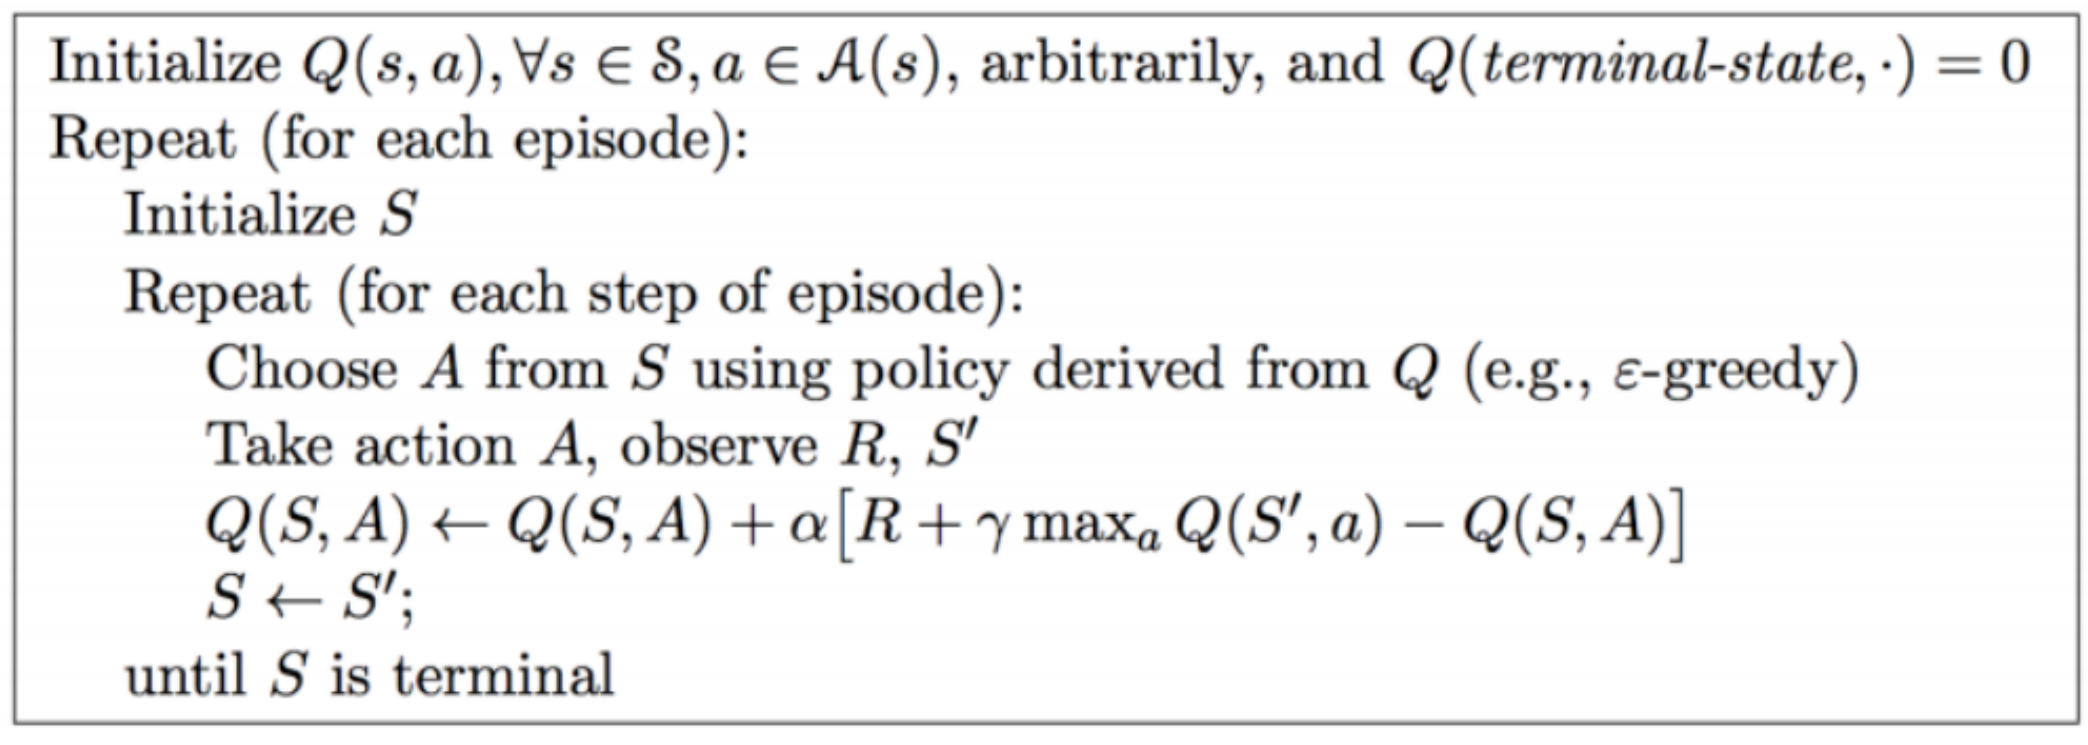

[Image Source](https://uoft-csc413.github.io/2022/)

In [1]:
import numpy as np
import gymnasium as gym
import random

In [10]:
# Create the environment
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array")

### Q-Table

Now, we need to create Q-table. A Q table helps us find the best action for each state. It gives us the Q-value for each state-action pair.<br>

To know how much rows (states) and columns (actions) we need, we need to calculate the action_size and the state_size. OpenAI Gym provides us a way to do that.

In [3]:
state_size = env.observation_space.n
action_size = env.action_space.n

state_size, action_size

(np.int64(16), np.int64(4))

In [4]:
# Create our Q table with state_size rows and action_size columns (64x4). We can set all values to zero for now.
qtable = np.zeros((state_size, action_size))
print(qtable)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


### Exploration vs Exploitation

Notice that Q-learning only learns about the states and actions it visits. What if an optimal state remains unvisited due to not being explored. The agent should sometimes pick suboptimal actions in order to visit new states and actions. <br>

A simple strategy is to use an $\epsilon$-greedy policy. According to this policy, the agent takes a random action with epsilon probability. The value of epsilon is high at the start of training and low towards the end. So, the agent explores more at the start and then exploit the learned policy more at the end.

### Hyperparameters

In [5]:
# Here, we will specify the hyperparameters

total_episodes = 20000       # Total training episodes
learning_rate = 0.1          # Learning rate
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 0.0005           # Exponential decay rate for exploration prob

### Training

In [6]:
# List of rewards
rewards = []

for episode in range(total_episodes):
    # Reset the environment
    state, _ = env.reset()
    step = 0
    done = False
    total_rewards = 0

    for step in range(max_steps):
        # Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)

        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])

        # Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()


        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # Update Q(s,a):= Q(s,a) + lr * [R(s,a) + gamma * max Q(s',a') * (1-done) - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) * (1-done) - qtable[state, action])

        total_rewards += reward

        # Our new state is state
        state = new_state

        # If done (if we're dead) : finish episode
        if done == True:
            break

    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    rewards.append(total_rewards)
    print(f"Episode {episode}: Reward = {total_rewards}, Epsilon = {epsilon}")


print ("Score over time: " +  str(sum(rewards)/total_episodes))
print(qtable)

Streaming output truncated to the last 5000 lines.
Episode 15017: Reward = 1.0, Epsilon = 0.010542919045917212
Episode 15018: Reward = 1.0, Epsilon = 0.010542647654247825
Episode 15019: Reward = 1.0, Epsilon = 0.010542376398240353
Episode 15020: Reward = 1.0, Epsilon = 0.010542105277826985
Episode 15021: Reward = 1.0, Epsilon = 0.010541834292939938
Episode 15022: Reward = 1.0, Epsilon = 0.01054156344351147
Episode 15023: Reward = 1.0, Epsilon = 0.010541292729473862
Episode 15024: Reward = 1.0, Epsilon = 0.01054102215075944
Episode 15025: Reward = 1.0, Epsilon = 0.01054075170730056
Episode 15026: Reward = 1.0, Epsilon = 0.010540481399029609
Episode 15027: Reward = 1.0, Epsilon = 0.01054021122587901
Episode 15028: Reward = 1.0, Epsilon = 0.010539941187781222
Episode 15029: Reward = 1.0, Epsilon = 0.010539671284668732
Episode 15030: Reward = 1.0, Epsilon = 0.010539401516474065
Episode 15031: Reward = 1.0, Epsilon = 0.010539131883129783
Episode 15032: Reward = 1.0, Epsilon = 0.010538862384

### Visualization

In [7]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [11]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state, _ = env.reset()
    done = False
    for t in range(max_steps):
        vid.capture_frame()
        action = np.argmax(qtable[state,:])
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        print(f"state: {state}, action: {action}",next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

In [12]:
show_video_of_model("FrozenLake-v1")

/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


state: 0, action: 1 4 0.0 False
state: 4, action: 1 8 0.0 False
state: 8, action: 2 9 0.0 False
state: 9, action: 1 13 0.0 False
state: 13, action: 2 14 0.0 False
state: 14, action: 2 15 1.0 True


In [13]:
show_video("FrozenLake-v1")